In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/eeg-head-image/DALLE 2024-08-27 19.06.50 - A simple clean and clear illustration of a human head in profile with a focus on the left side. The illustration should include an outline of the h.webp
/kaggle/input/epilepsy-detection-using-eeg-signals/eeg_data.csv


In [2]:
df = pd.read_csv('/kaggle/input/epilepsy-detection-using-eeg-signals/eeg_data.csv')
print(df.shape)
df.head()

(2216, 668)


,FP1_power_delta,FP1_power_theta,FP1_power_alpha,FP1_power_beta,FP1_power_gamma,FP2_power_delta,FP2_power_theta,FP2_power_alpha,FP2_power_beta,FP2_power_gamma,...,T5_STD_D4,T5_STD_D5,T5_STD_D6,T6_STD_D1,T6_STD_D2,T6_STD_D3,T6_STD_D4,T6_STD_D5,T6_STD_D6,epileptic_
0,15.980332,8.633358,3.092433,0.846559,0.372832,17.581626,9.937238,3.485713,0.945396,0.428797,...,31.427918,29.699413,32.013546,3.583559,12.529528,45.831132,61.890813,34.783454,33.245906,1
1,223.267803,41.573241,13.043525,6.463381,6.168712,298.274432,50.013025,14.411482,6.659230,4.942250,...,24.822720,47.185918,93.619195,14.158489,15.217886,30.927407,77.324322,153.442359,213.780950,1
2,158.673907,31.788608,9.956198,3.736977,2.926979,232.762741,39.332981,10.956081,3.478036,2.153082,...,21.708222,47.412375,85.729645,9.493639,11.824569,24.555772,59.229187,112.406306,171.618208,1
3,29.767326,3.875543,1.553127,0.438266,0.140495,45.206547,5.173542,2.028637,0.528962,0.161283,...,26.319506,39.628894,51.473202,1.872515,5.392639,17.296780,35.824586,44.892899,79.613460,1
4,33.821075,3.635210,1.347280,0.313205,0.080396,55.670043,4.925017,1.783729,0.394463,0.102254,...,26.111048,39.177537,52.925676,1.408291,4.556997,12.733549,25.676801,44.406617,94.770581,1


We have a dataset that consists of 2216 rows, each presents an EEG examination of multiple different channels on a person's scalp with different frequency bands.

The table consists of 668 columns - 253 columns present values of diffrent frequencies recorded on the EEG checkup on different places on the person's saclp.

The remaining columns present recordings of LSWT - local sleep-wake transition bands across different times, and statistical values from a specific check up, such as mean and std of a frequency recorded on a speciic part of the scalp and on different times (D1,D2,etc...).

At the end of the table we see the Target - wether the pesron that went through the examination is epileptic or not (1,0)

In this notebook I would try to characterize the main features of an EEG checkup that may indicate wether or not a person has Epilepsy and create multiple predictive model that when given the selected features would be able to adequatly predict Epilepsy.

**EDA**

In [4]:
### Num of duplicate rows - neglectable
df.duplicated().sum()

8

In [5]:
df.isnull().sum().value_counts()
### No NaN Values 

0    668
Name: count, dtype: int64

At First glance we see no missing values, however a quick view at the features table shows a lot of 0s in columns that otherwise have decimal readings of EEG frequancies. 

I will examine these columns as they may be features that should be excluded when training predicitve models

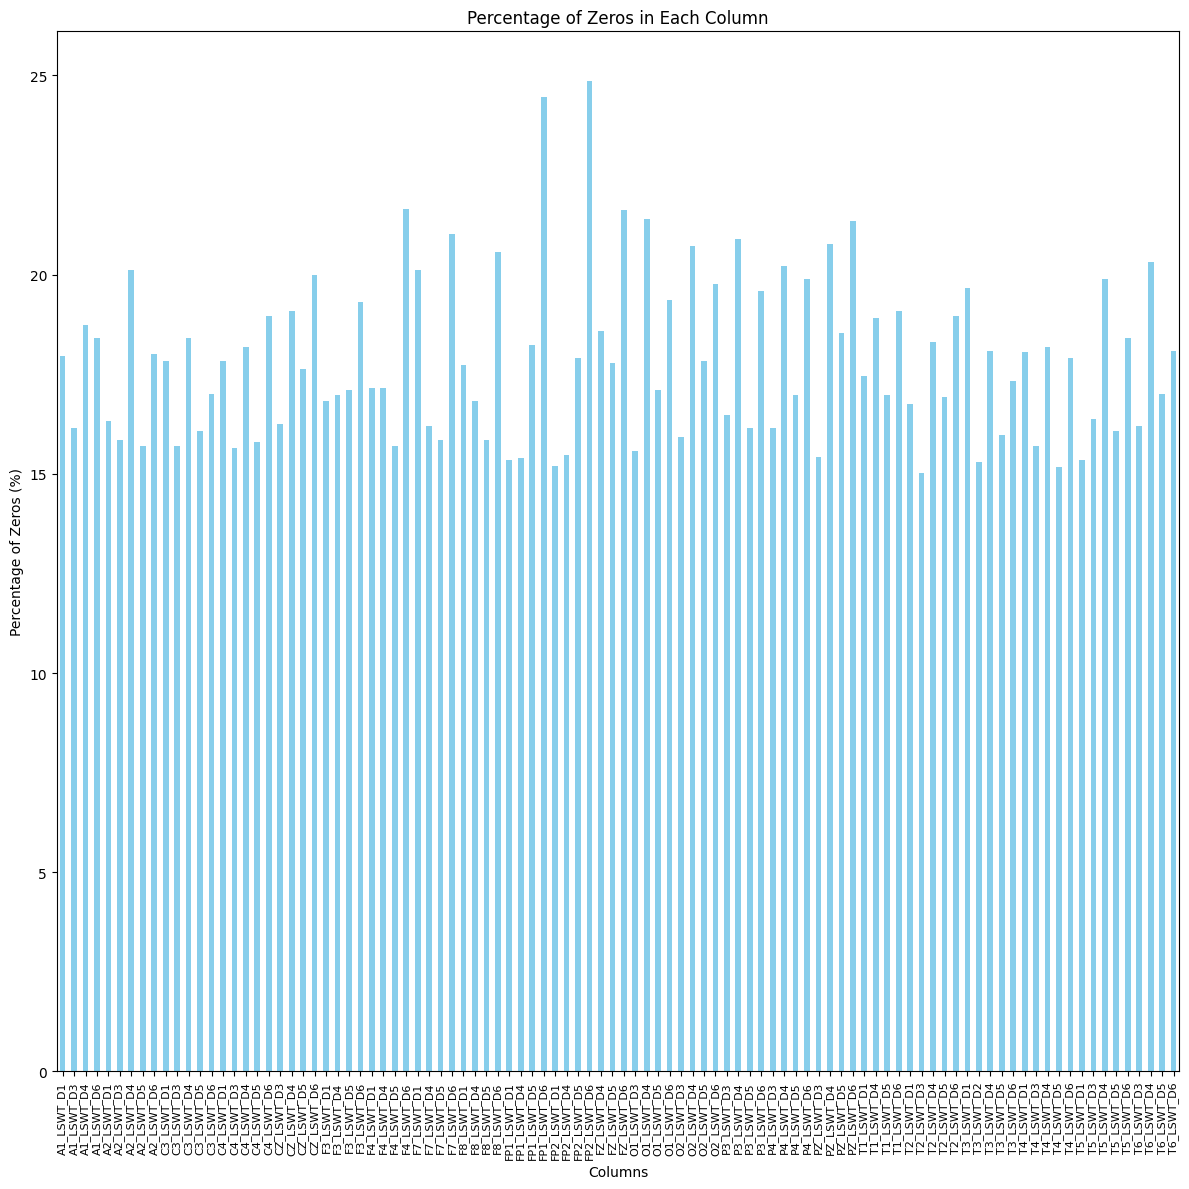

A1_LSWT_D1    17.960289
A1_LSWT_D3    16.155235
A1_LSWT_D4    18.727437
A1_LSWT_D6    18.411552
A2_LSWT_D1    16.335740
                ...    
T5_LSWT_D6    18.411552
T6_LSWT_D3    16.200361
T6_LSWT_D4    20.306859
T6_LSWT_D5    17.012635
T6_LSWT_D6    18.095668
Length: 98, dtype: float64


In [6]:
zero_counts = (df == 0).sum()

zero_percentage = (zero_counts / len(df)) * 100

### I want to view only the features that have more than 15% of their values equal to 0

zero_percentage = zero_percentage[(zero_percentage>=15) & (zero_percentage.index != 'epileptic_')]

plt.figure(figsize=(12, 12))
zero_percentage.plot(kind='bar', color='skyblue')
plt.title('Percentage of Zeros in Each Column')
plt.xlabel('Columns')
plt.ylabel('Percentage of Zeros (%)')
plt.xticks(rotation=90, ha='center', fontsize=8)  
plt.tight_layout()  
plt.show()
print(zero_percentage)

#Saving the columns for future use
columns_with_zeros = zero_percentage.index.to_list()

These features have more than 15% precent of their values equal to zero which I persume is equivalent to NAs. 
We can see from the plot all values are of LSWT across different parts of the brain and times.

LSWT - Local Sleep-Wake Transition in another scale being examined in EEGs.

However I've set a threshold of 15% or more values missing as a condition if features values should be dropped or not therefore I am going to drop the LSWT readings before training models.

In [7]:
df.dtypes.value_counts()
### 667 features of frequencies , Target is Binary (1,0)

float64    667
int64        1
Name: count, dtype: int64

In [8]:
non_epileptic = df[df['epileptic_'] == 0]
epileptic = df[df['epileptic_'] == 1]
print("Targets : ",'\n' ,"Num of Epileptic : ", len(epileptic),'\n', "Num of Non Epileptic : ", len(non_epileptic) )

Targets :  
 Num of Epileptic :  1020 
 Num of Non Epileptic :  1196


Using Point-Biseral Correliation Coefficient to try and evaluate the most impactful features on the Target

The Point-Biserial Correlation is a special case of the Pearson correlation coefficient used when one variable is continuous, and the other is binary (dichotomous). It measures the strength and direction of the association between the continuous variable and the binary target.

The values of the the correlation travel between [-1,1] where values closer to 1 indicate of the varable's correlation to value 1 (yes) of the target and those closer to -1 indicate correlation of the variable to the value 0 (no) of the target

In [9]:
import scipy.stats as stats
import matplotlib.pyplot as plt
correlations = []

for col in df.columns:
    if col != 'epileptic_':
        r_pb, p_value = stats.pointbiserialr(df[col], df['epileptic_'])
        correlations.append((col, r_pb, p_value))

correlation_df = pd.DataFrame(correlations, columns=['Feature', 'Point-Biserial Correlation', 'p-value'])
correlation_df['Absolute Correlation'] = correlation_df['Point-Biserial Correlation'].abs()
correlation_df = correlation_df.sort_values(by='Absolute Correlation', ascending=False)
correlation_df = correlation_df.drop(columns='Absolute Correlation')
# Display the top 15 most correlated features

print(correlation_df.head(15))



            Feature  Point-Biserial Correlation       p-value
535       A2_STD_D1                    0.122089  8.136264e-09
397  A2_Mean_Abs_D1                    0.119720  1.577606e-08
131      C3_LSWT_D5                   -0.107037  4.408898e-07
400  A2_Mean_Abs_D4                    0.102783  1.243566e-06
391  A1_Mean_Abs_D1                    0.102365  1.374022e-06
529       A1_STD_D1                    0.101737  1.595029e-06
536       A2_STD_D2                    0.100601  2.084147e-06
221      T1_LSWT_D5                   -0.094140  9.040377e-06
401  A2_Mean_Abs_D5                    0.093358  1.072945e-05
202      P3_LSWT_D4                   -0.093231  1.103159e-05
121      A2_LSWT_D1                    0.089965  2.222728e-05
399  A2_Mean_Abs_D3                    0.089890  2.258326e-05
402  A2_Mean_Abs_D6                    0.089849  2.277587e-05
398  A2_Mean_Abs_D2                    0.087966  3.373700e-05
161      F7_LSWT_D5                   -0.085460  5.623246e-05


These are the 15 most correlated features in Absolute Value - I wanted to get these features in order to visualize the regions on the head that significal EEG readings in them impact mostly on exsitence of Epilepsy.

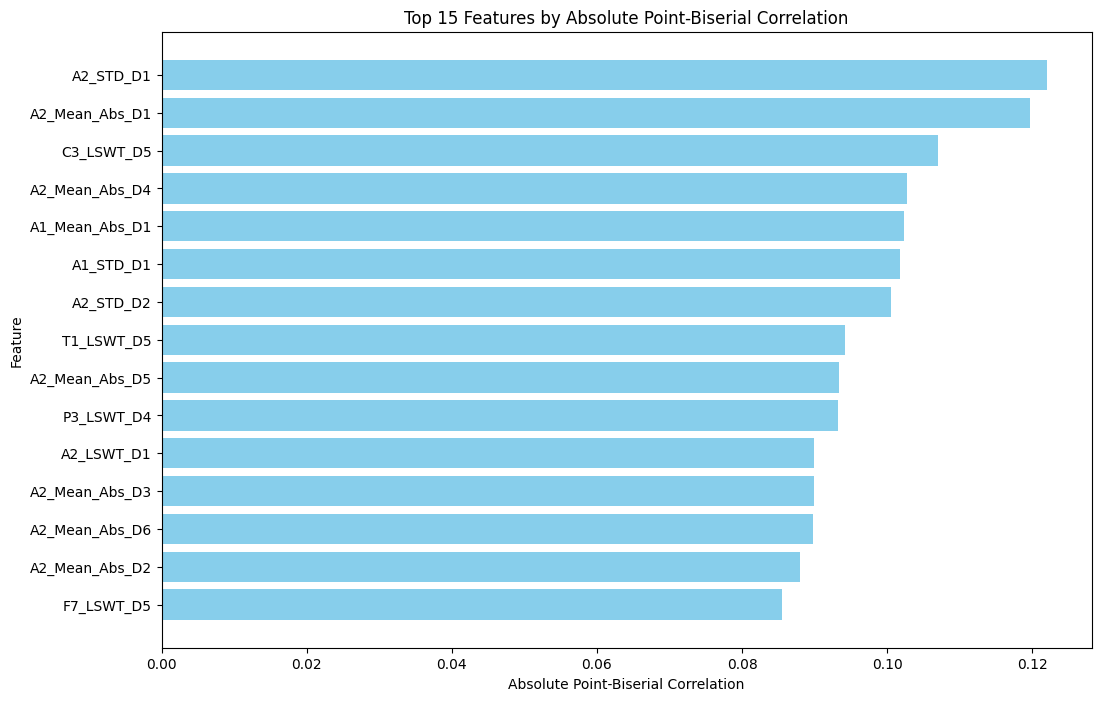

In [10]:
plt.figure(figsize=(12, 8))
plt.barh(correlation_df['Feature'].head(15),abs(correlation_df['Point-Biserial Correlation']).head(15),color = 'skyblue')
plt.xlabel('Absolute Point-Biserial Correlation')
plt.ylabel('Feature')
plt.title('Top 15 Features by Absolute Point-Biserial Correlation')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest values on top
plt.show()

As mentioned before each of the columns' names represent an ingredient of the EEG examination.

* The first part of a column's string represents the location of the electrode that was placed on the patient's head - We can clearly see that from our dataset A2 readings are highly correlated with the target - *A2 is the region of the right ear on the head*

* The second part of the string (seperated by "_") either represents The power of the EEG signal in the specified frequency band, reflecting the amplitude of the waves in that band. Or a statistical measure of a certain electrode placement (Mean,Std,LSWT).

* The third part (when exists) represnts hierarchical timeline as D1 comes before D2 and D3 (I assume it means different statistical measures gathered on the same patient across different days but this is not confirmed in Kaggle)




***Head Regions Visualization***

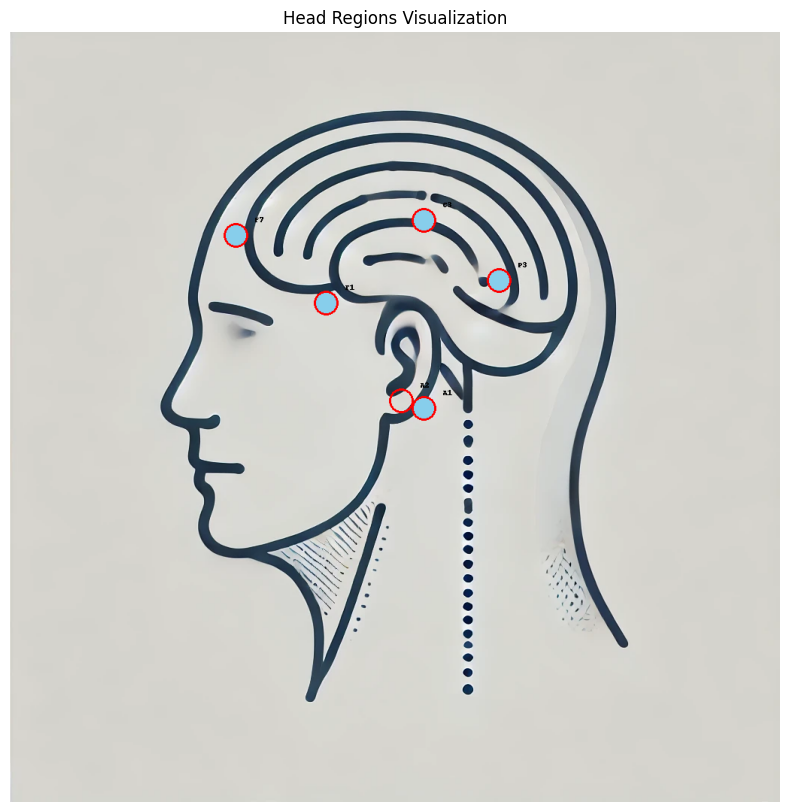

In [11]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

img = Image.open('/kaggle/input/eeg-head-image/DALLE 2024-08-27 19.06.50 - A simple clean and clear illustration of a human head in profile with a focus on the left side. The illustration should include an outline of the h.webp')  # Replace with correct paths
draw = ImageDraw.Draw(img)
font = ImageFont.load_default()
points = {
    "A1": (550, 500),  # Left earlobe
    "A2": (520, 490),  # Right earlobe
    "C3": (550, 250),  # Left side, midway between ear and top of head
    "T1": (420, 360),  # Left temple
    "P3": (650, 330),  # Left parietal bone
    "F7": (300, 270),  # Left forehead near hairline
}

point_radius = 16  
outline_color = 'red'
fill_color = 'skyblue'
for label, (x, y) in points.items():
    if label == "A2":
        draw.ellipse((x-point_radius, y-point_radius, x+point_radius, y+point_radius), outline=outline_color, width=3)
    else:
        draw.ellipse((x-point_radius, y-point_radius, x+point_radius, y+point_radius), fill=fill_color, outline=outline_color, width=3)
    draw.text((x + point_radius + 10, y - point_radius - 10), label, fill="black", font=font)


img.save("/kaggle/working/eeg_head_diagram_with_larger_points.png")

plt.figure(figsize=(10, 10))
plt.title("Head Regions Visualization")
plt.imshow(img)
plt.axis('off') 
plt.show()

Siginifical entries in these locations may indicate exsitence of Epilepsy as these are the locations that were found most correlated with the target.

**Checking Data Correlation**


In [12]:
# corr = df.copy()
# corr.drop(columns = 'epileptic_')

# Compute the correlation matrix
corr_matrix = df.drop(columns='epileptic_').corr().abs()  # Use absolute values for correlation

# Find column pairs with correlation greater than 0.9
high_corr_pairs = []

# Loop through the correlation matrix to find highly correlated pairs
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if corr_matrix.iloc[i, j] > 0.99:  # Only consider correlations above 0.9
            colname1 = corr_matrix.columns[i]
            colname2 = corr_matrix.columns[j]
            high_corr_pairs.append((colname1, colname2))

# Print the pairs of highly correlated columns
print("Columns with correlation > 0.9:")
for pair in high_corr_pairs:
    print(pair)

Columns with correlation > 0.9:
('C4_power_gamma', 'C3_power_gamma')
('P3_power_theta', 'C4_power_theta')
('P3_power_alpha', 'C4_power_alpha')
('P4_power_theta', 'C4_power_theta')
('P4_power_beta', 'C4_power_beta')
('O1_power_theta', 'C3_power_theta')
('O2_power_theta', 'P3_power_theta')
('O2_power_alpha', 'P3_power_alpha')
('O2_power_beta', 'P3_power_beta')
('O2_power_gamma', 'C3_power_gamma')
('O2_power_gamma', 'O1_power_gamma')
('T3_power_theta', 'P3_power_theta')
('T3_power_beta', 'O2_power_beta')
('T3_power_gamma', 'O1_power_gamma')
('T5_power_theta', 'P3_power_theta')
('T5_power_theta', 'O2_power_theta')
('T5_power_theta', 'T3_power_theta')
('T5_power_alpha', 'T3_power_alpha')
('T5_power_beta', 'P3_power_beta')
('T5_power_beta', 'O2_power_beta')
('T5_power_beta', 'T3_power_beta')
('T5_power_gamma', 'O1_power_gamma')
('T5_power_gamma', 'T3_power_gamma')
('T6_power_alpha', 'FP2_power_alpha')
('T6_power_beta', 'FP2_power_beta')
('T6_power_gamma', 'FP1_power_gamma')
('FZ_power_theta'

**Data Prepration**

Since all our features are numerical and the target is binary, with no missing values (except the zeros), the only preprations needed are to detect data outliers and handle them and than normalize the entire dataset

First we split the data to train and test in order to prevent Data Leakage when training models

In [13]:
from sklearn.model_selection import train_test_split

X = df.drop(columns='epileptic_')
y = df['epileptic_']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

In [14]:
print(X_train.duplicated().sum())
print(X_test.duplicated().sum())

25
2


In [15]:
X_train.drop(columns = columns_with_zeros, inplace= True)
X_test.drop(columns = columns_with_zeros,inplace = True)
print("Train Shape:  ",X_train.shape, '\n', "Test Shape:  ", X_test.shape )

Train Shape:   (1662, 569) 
 Test Shape:   (554, 569)


In [16]:
q1 = X_train.quantile(0.25)
q3 = X_train.quantile(0.75)

IQR = q3 - q1

outliers = (X_train < (q1 - 2.5 * IQR)) | (X_train > (q3 + 2.5 * IQR))
outliers_test = (X_test < (q1 - 2.5 * IQR)) | (X_test > (q3 + 2.5 * IQR))
outliers_count = outliers.sum()
print("Total Amount of Outliers : ", outliers_count.sum(),'\n',"Precentage of Outliers out of Entire Data Points : ", str(outliers_count.sum()/(X_train.shape[0]*X_train.shape[1])*100) + "%")

outliers_count = pd.DataFrame(outliers_count)

outliers_count

Total Amount of Outliers :  96835 
 Precentage of Outliers out of Entire Data Points :  10.239743337584253%


,0
FP1_power_delta,162
FP1_power_theta,217
FP1_power_alpha,212
FP1_power_beta,180
FP1_power_gamma,174
...,...
T6_STD_D2,123
T6_STD_D3,126
T6_STD_D4,155
T6_STD_D5,179


I used the IQR of each coloumn to identify significant outliers that may inflict bias when training the predictive model. 

I will convert the outliers in each column to the median value of that column, as Median values tend to be less biased.

Again, I used the median value for each column in the **train** data and it sets the theshold for outliers in the test as well. Also test's outliers would be handled with the median values of the train.

In [17]:
X_train = X_train.mask(outliers, X_train.median(), axis=1)
### Handling the test data the same way I handle the train because I assume no knowledge of it before modeling.
X_test = X_test.mask(outliers_test,X_train.median(),axis=1)

In [18]:
print(X_train.duplicated().sum())
print(X_test.duplicated().sum())

25
2


In [19]:
#### Making Sure Outliers were dealt with

outliers = (X_train < (q1 - 2.5 * IQR)) | (X_train > (q3 + 2.5 * IQR))

outliers_count = outliers.sum()
outliers_count

FP1_power_delta    0
FP1_power_theta    0
FP1_power_alpha    0
FP1_power_beta     0
FP1_power_gamma    0
                  ..
T6_STD_D2          0
T6_STD_D3          0
T6_STD_D4          0
T6_STD_D5          0
T6_STD_D6          0
Length: 569, dtype: int64

**Features Standardization**

In [20]:
X_train.describe()

,FP1_power_delta,FP1_power_theta,FP1_power_alpha,FP1_power_beta,FP1_power_gamma,FP2_power_delta,FP2_power_theta,FP2_power_alpha,FP2_power_beta,FP2_power_gamma,...,T5_STD_D3,T5_STD_D4,T5_STD_D5,T5_STD_D6,T6_STD_D1,T6_STD_D2,T6_STD_D3,T6_STD_D4,T6_STD_D5,T6_STD_D6
count,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,...,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000,1662.000000
mean,136.938605,13.810080,5.819892,3.112635,1.635609,150.037850,13.821983,6.066999,3.119162,1.634657,...,16.982048,21.250238,29.249568,48.164852,7.476167,9.894795,18.587275,25.004123,35.029693,59.724495
std,189.963338,17.864214,7.128380,3.986150,2.026365,201.996088,16.472021,7.169220,3.895864,2.041326,...,11.123643,14.633790,24.723691,41.153887,5.843098,6.147793,11.497746,17.880276,30.541383,54.274499
min,0.025945,0.012101,0.009409,0.007828,0.008412,0.026174,0.018836,0.010871,0.006120,0.006863,...,0.900698,0.950777,1.057651,1.118569,0.525890,0.846936,0.892331,0.909989,0.918962,1.115070
25%,24.839627,3.886816,1.847510,0.786946,0.375825,27.072093,4.227166,1.988075,0.843519,0.399621,...,9.767422,12.389701,14.893013,23.975430,3.498838,5.831769,11.162284,14.156674,16.623008,26.504449
50%,68.088215,8.638260,3.779233,1.780455,0.953515,72.020589,9.661813,4.120762,1.850891,0.960221,...,14.297640,18.627806,23.650949,38.922114,5.870252,8.585689,15.878251,20.971056,26.945473,44.417652
75%,136.987401,13.232494,5.898511,3.196949,1.855008,163.867787,14.724992,6.178163,3.195189,1.876074,...,19.511040,24.713613,31.000844,52.849274,9.691016,11.478106,21.726944,27.898533,38.714763,66.124728
max,875.259402,92.919920,35.126829,20.571731,11.430081,945.462809,86.745411,36.084102,20.802789,11.685969,...,62.665391,82.096171,142.843159,226.719771,30.601488,35.359155,66.960644,91.309662,157.354093,293.337475


A quick glance on the 'Describe' table shows that each column has different values in it, some have more negative values some postive etc. Since I want to train a logistic regression model as a baseline I will create a normalized copy of the train and test data

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)

X_train_N = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)

print("Mean and Std Values of the first column :",X_train_N.iloc[:,0].mean(),X_train_N.iloc[:,0].std())

X_train_N.head(5)

Mean and Std Values of the first column : 4.488988402816517e-17 1.0003009781858971


,FP1_power_delta,FP1_power_theta,FP1_power_alpha,FP1_power_beta,FP1_power_gamma,FP2_power_delta,FP2_power_theta,FP2_power_alpha,FP2_power_beta,FP2_power_gamma,...,T5_STD_D3,T5_STD_D4,T5_STD_D5,T5_STD_D6,T6_STD_D1,T6_STD_D2,T6_STD_D3,T6_STD_D4,T6_STD_D5,T6_STD_D6
0,-0.222363,-0.230086,-0.469863,-0.658586,-0.733717,0.260466,0.130855,-0.347783,-0.629835,-0.696830,...,-0.382842,0.221497,0.633384,0.225166,-1.006852,-0.871478,-0.404098,0.582422,1.088873,0.813457
1,0.369118,-0.061703,0.798409,-0.333920,-0.336634,-0.386017,0.581059,1.402237,-0.325496,-0.330008,...,-0.477916,-0.471758,-0.539389,-0.445518,-0.342520,-0.386225,-0.395921,-0.388651,-0.457831,-0.463727
2,-0.290099,-0.195619,-0.338557,-0.348755,-0.446336,-0.283326,-0.154775,-0.391222,-0.510260,-0.596060,...,-0.191500,-0.087327,-0.310691,-0.476423,-0.422519,-0.386325,-0.477372,-0.204884,-0.014350,-0.062379
3,-0.276290,-0.395880,-0.542866,-0.657809,-0.737067,-0.223884,-0.362710,-0.522447,-0.650077,-0.714487,...,-0.804095,-0.139544,0.332315,0.573222,-0.911831,-1.035316,-0.990048,-0.439181,-0.209771,-0.218819
4,0.133549,-0.358123,-0.438901,-0.612418,-0.713815,0.199411,-0.372726,-0.447542,-0.621200,-0.706586,...,-0.397007,-0.048475,0.713949,1.116346,-0.933136,-0.605907,-0.410710,-0.294286,0.392179,1.413550


In [22]:
### Applying the same for X_test 


X_test_N = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

print("Mean and Std Values of the first column :",X_test_N.iloc[:,0].mean(),X_test_N.iloc[:,0].std())

X_test_N.head(5)


Mean and Std Values of the first column : 0.020080890648511623 1.0198545872657863


,FP1_power_delta,FP1_power_theta,FP1_power_alpha,FP1_power_beta,FP1_power_gamma,FP2_power_delta,FP2_power_theta,FP2_power_alpha,FP2_power_beta,FP2_power_gamma,...,T5_STD_D3,T5_STD_D4,T5_STD_D5,T5_STD_D6,T6_STD_D1,T6_STD_D2,T6_STD_D3,T6_STD_D4,T6_STD_D5,T6_STD_D6
0,0.681131,-0.289594,-0.286359,1.684104,0.495825,0.663574,-0.252636,-0.271553,2.707149,1.140045,...,1.088519,1.967025,0.799305,-0.380125,-0.199702,0.374531,0.559751,1.279679,0.442165,-0.446118
1,-0.348232,-0.331659,-0.310530,-0.059003,0.127153,-0.266486,-0.179751,-0.341751,-0.312546,-0.248082,...,0.014819,0.250374,-0.102463,-0.227622,-0.126554,-0.186281,-0.229742,0.249202,0.374687,0.319531
2,-0.537268,-0.545222,0.393622,1.890702,1.678391,-0.400349,-0.187665,2.713447,-0.325641,-0.330491,...,-0.826664,-0.891856,-0.456438,0.047617,0.149947,-0.084071,-0.799096,-0.679575,0.126735,0.389285
3,-0.510260,-0.611460,-0.624808,-0.535333,-0.482512,-0.491074,-0.613316,-0.627944,-0.629526,-0.616439,...,-0.289630,-0.388636,-0.430391,-0.475084,-0.195733,-0.252546,0.147546,-0.233028,-0.464824,-0.531855
4,-0.501840,-0.596657,-0.629626,-0.655593,-0.712090,-0.563981,-0.638976,-0.636837,-0.673831,-0.724199,...,-0.520041,-0.404012,-0.306185,-0.368875,-0.946663,-0.782097,-0.542512,-0.448196,-0.398791,-0.459441


**Model Selection**

**Logistic Regression** - Baseline Model

In [23]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix,classification_report,roc_curve, auc
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import math
import seaborn as sns


log_reg = LogisticRegression(max_iter=10000)

test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []

all_predictions = []
all_true_values = []

kf = KFold(n_splits=5, shuffle=True, random_state=123)

### CV loop
for train_index, test_index in kf.split(X_train_N):
    X_train_fold = X_train_N.iloc[train_index]
    X_test_fold = X_train_N.iloc[test_index]
    y_train_fold = y_train.iloc[train_index]
    y_test_fold = y_train.iloc[test_index]

    log_reg.fit(X_train_fold, y_train_fold)

    y_train_pred_prob = log_reg.predict_proba(X_train_fold)[:, 1]
    y_test_pred_prob = log_reg.predict_proba(X_test_fold)[:, 1]

    y_train_pred = log_reg.predict(X_train_fold)
    y_test_pred = log_reg.predict(X_test_fold)

    train_loss = log_loss(y_train_fold, y_train_pred_prob)
    test_loss = log_loss(y_test_fold, y_test_pred_prob)

    train_acc = accuracy_score(y_train_fold, y_train_pred)
    test_acc = accuracy_score(y_test_fold, y_test_pred)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    all_predictions.append(y_test_pred)
    all_true_values.append(y_test_fold)
    
print("AVG Accuracy: ", np.mean(test_accuracies) ,'\n', "AVG Normalized Log Loss : ", np.mean(test_losses))

AVG Accuracy:  0.7418719924744022 
 AVG Normalized Log Loss :  1.2082493863225252


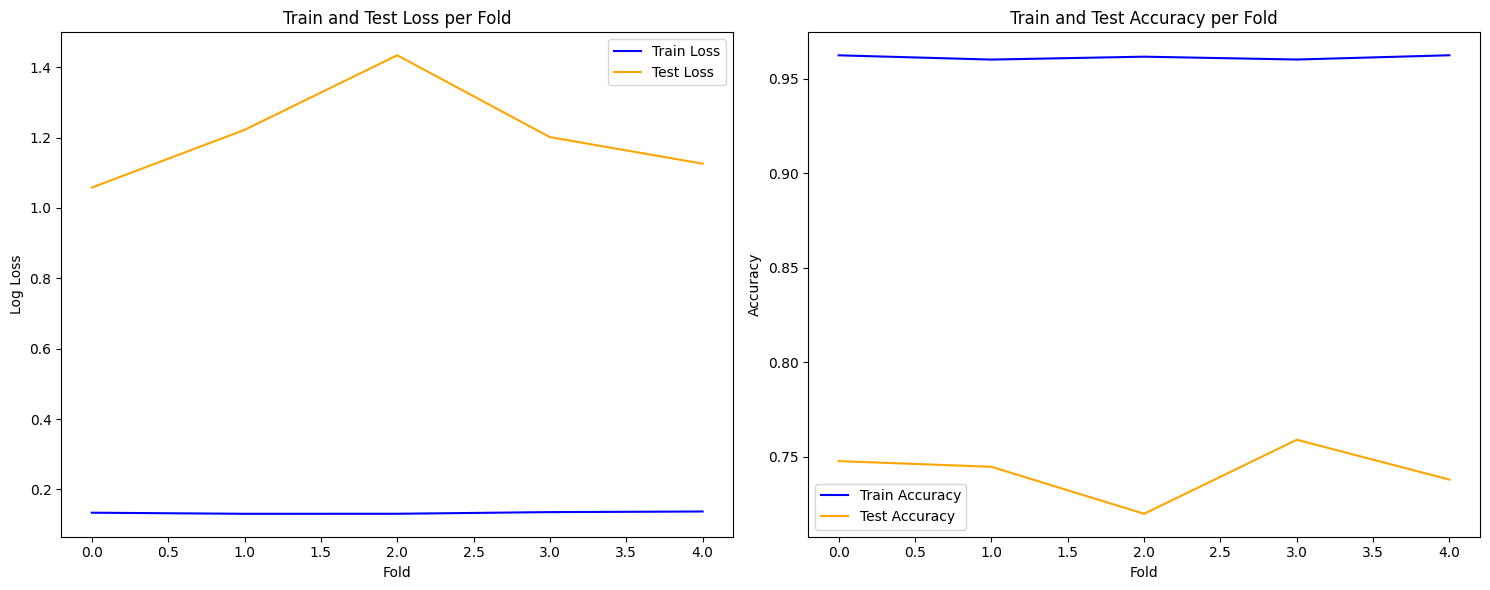

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Plot training and test losses
ax[0].plot(train_losses, label='Train Loss', color='blue')
ax[0].plot(test_losses, label='Test Loss', color='orange')
ax[0].set_title('Train and Test Loss per Fold')
ax[0].set_xlabel('Fold')
ax[0].set_ylabel('Log Loss')
ax[0].legend()

ax[1].plot(train_accuracies, label='Train Accuracy', color='blue')
ax[1].plot(test_accuracies, label='Test Accuracy', color='orange')
ax[1].set_title('Train and Test Accuracy per Fold')
ax[1].set_xlabel('Fold')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()

plt.show()

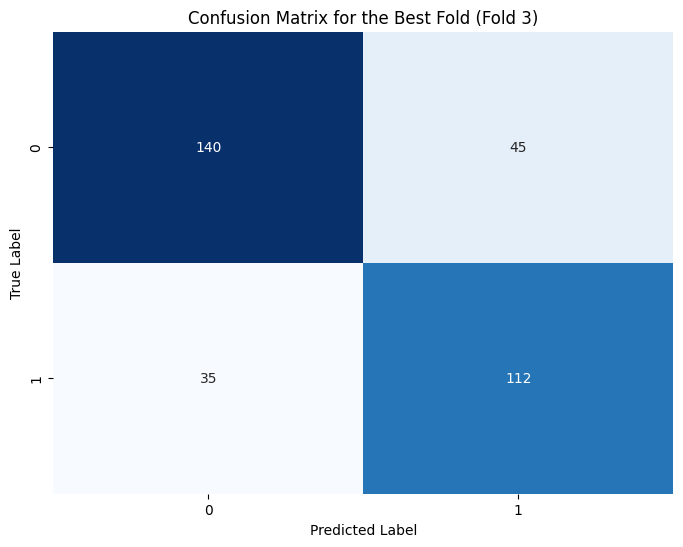

In [25]:
best_fold_index = np.argmax(test_accuracies)

best_predictions = all_predictions[best_fold_index]
best_true_values = all_true_values[best_fold_index]


# Plot confusion matrix for the best fold
conf_matrix = confusion_matrix(best_true_values, best_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix for the Best Fold (Fold {best_fold_index})')
plt.show()

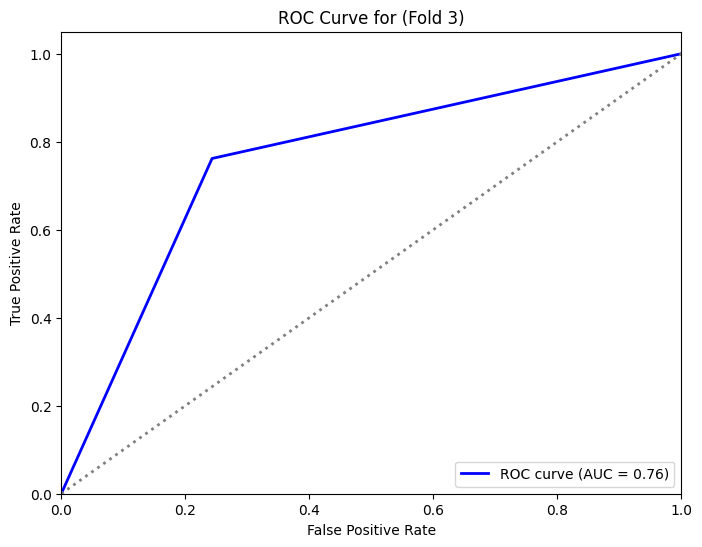

In [26]:
fpr, tpr, _ = roc_curve(best_true_values,best_predictions) 
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='dotted', lw=2) 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for (Fold {best_fold_index})')
plt.legend(loc="lower right")
plt.show()

**Baseline Model Preformance**

We can see decent performance of the baseline model. With an AVG accuracy of 74%. However AVG cross-entropy loss is pretty high indicating the model tends to give high probabilities to false predictions, this could be becasue of class imbalance in the given data taget (although here it is almost perfectly balanced) or the need of imputing a regulazation methods in future uses. 

I have also created plots of the the train and test loss and accuracy to see the model's robustness and consistency, across 5 folds we can see values varying but not to much. This may indicate the fit of this model to this classification problem given the same dataset with a larger scale.

I have added the best folds' plots of confusion matrix and RUC curve - with 75.9% accuracy and 76% AUC the model does seem to have the potential of extinguishing TP from FP and achieving better predictions with some fine tuning.


**Random Forest**

In [27]:
from sklearn.ensemble import RandomForestClassifier


rf_model = RandomForestClassifier(random_state=123,class_weight='balanced')
rf_model.fit(X_train, y_train)


y_pred_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)[:, 1]
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.8393501805054152
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       298
           1       0.82      0.83      0.83       256

    accuracy                           0.84       554
   macro avg       0.84      0.84      0.84       554
weighted avg       0.84      0.84      0.84       554



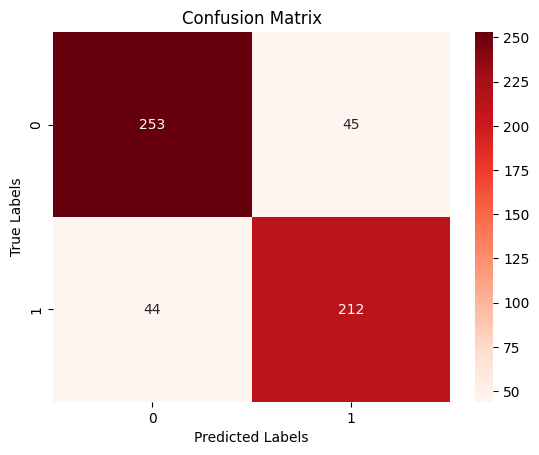

In [28]:
import seaborn as sns
conf_matrix = confusion_matrix(y_test, y_pred_rf)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

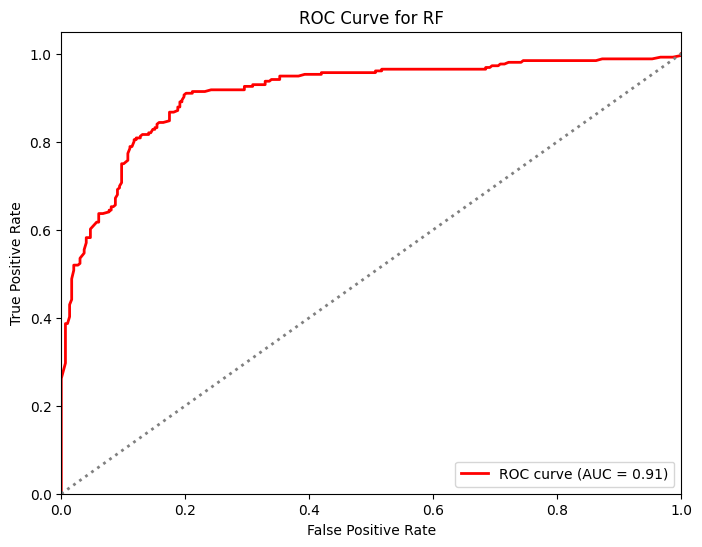

In [29]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_rf ) 
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='dotted', lw=2) 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for RF')
plt.legend(loc="lower right")
plt.show()

****Performance****

The model seems to perform well with an accuracy of 83.9% it achived better results than of the logistic regression model's.
Also, with and AUC of 0.91, we can almost say for certain, the model is able to identify epilepsy's EEG readings from those that aren't associated wit eplipesy. That is a big leap forward from the baseline model 

However, as seen below the random forest classifier uses all the features from the dataset. When thinkning of futre more scalable uses for classifier, predictions we may get biased results as this trained model probably suffers from overfitting. 

In order to verify the model's good fit for the epilepsy classification problem, I would attempt in trying to reduce the number of features while still preserving accuracy and AUC using feature importance analysis.

****Presentation of a single tree in the model****

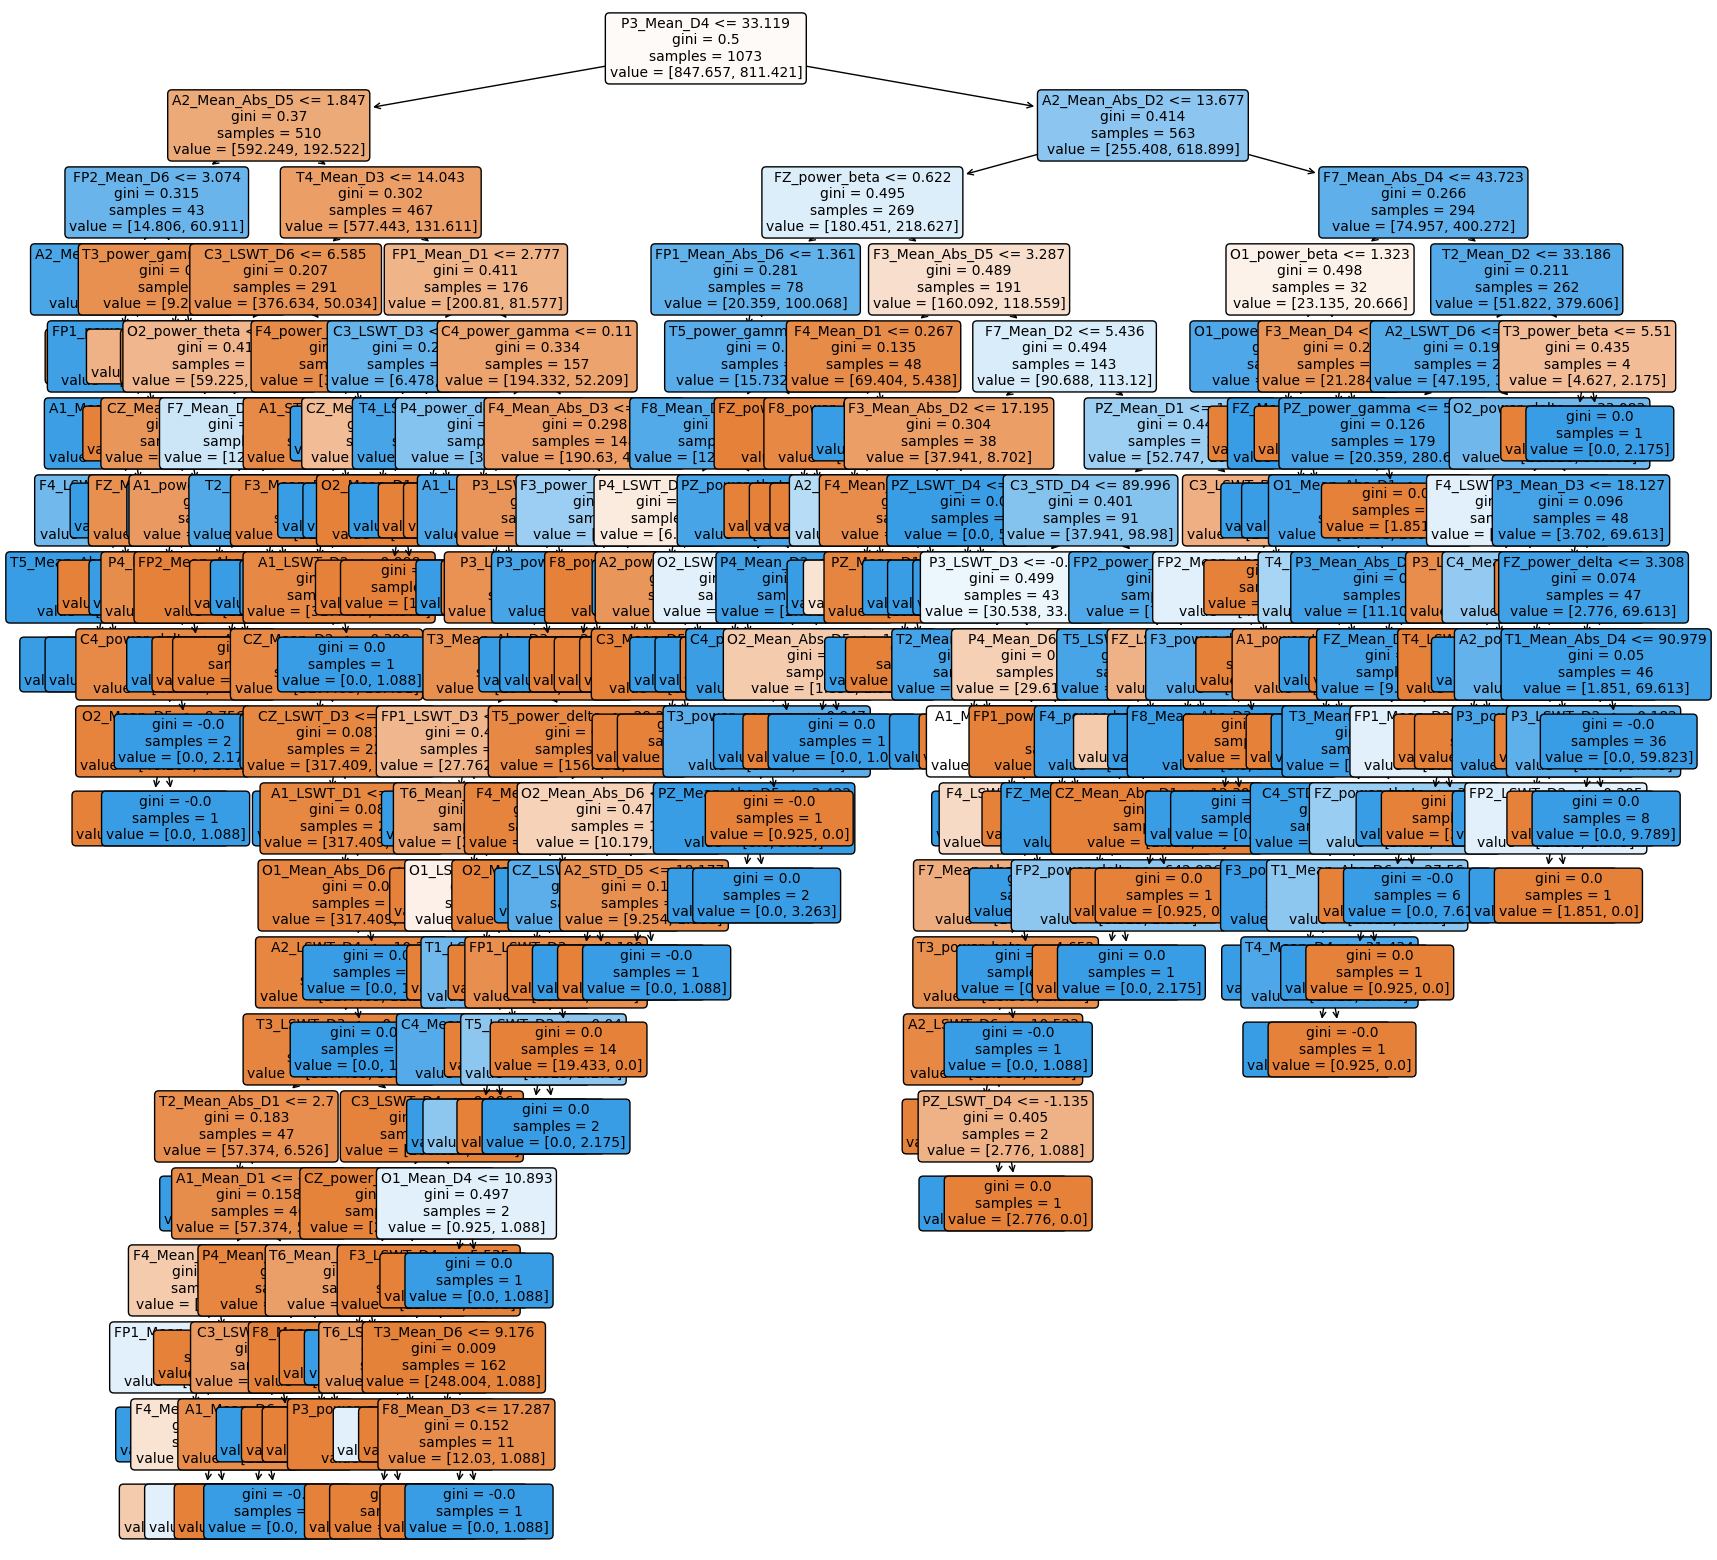

In [30]:
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree

# Select a single tree from the Random Forest
single_tree = rf_model.estimators_[0]  # First tree in the forest

# Plot the tree
plt.figure(figsize=(20,20))
plot_tree(single_tree, filled=True, feature_names=X.columns, rounded=True, fontsize=10)
plt.show()


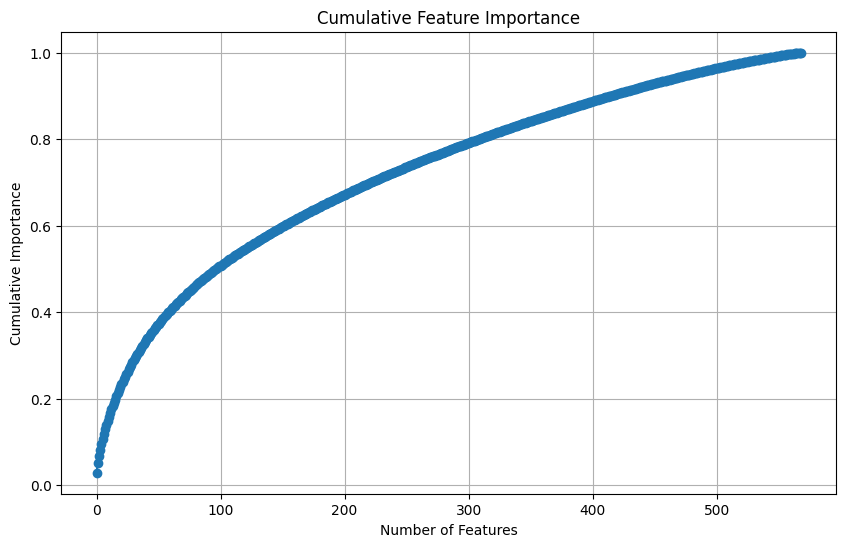

In [31]:
importances = rf_model.feature_importances_

indices = np.argsort(importances)[::-1]

cumulative_importance = np.cumsum(importances[indices])
# cumulative_importance = importances[indices]
plt.figure(figsize=(10, 6))
plt.plot(range(len(cumulative_importance)), cumulative_importance, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Feature Importance')
plt.grid(True)
plt.show()

***Feature Importnance***

Here we can see that when cumulative summing the features' importances (in a descending order, meaning the most important features are at the begining), we achieve 50% cumulative importance at when using the top 100 features, that is about 1/6 fo the entire featuers' columns. 

This indicates feature selection is critical when building a Decision Tree as many features don't contribute much to its learning and could only cause overfit. 


I will now set 5 thresholds of cumulative importances, for each I will derive the specifc features that contributed to get the cumulative importance of that threshold (Set from the most important ones, to the least important) and that try to evaluate how does the classifer perform with each number of features.

In [32]:
thresholds = [0.5,0.6,0.7,0.8,0.9]
X_reduced = []
for th in thresholds:
    num_features = np.argmax(cumulative_importance >= th) + 1
    print(f"Number of features to retain for {th*100}% cumulative importance: {num_features}")
    top_features = X.columns[indices][:num_features]
    X_reduced.append(X[top_features])
X_reduced_copy = X_reduced

Number of features to retain for 50.0% cumulative importance: 98
Number of features to retain for 60.0% cumulative importance: 152
Number of features to retain for 70.0% cumulative importance: 222
Number of features to retain for 80.0% cumulative importance: 309
Number of features to retain for 90.0% cumulative importance: 416


In [33]:
best_accuracy = 0
best_threshold = 0
best_model = None
best_report = ""
accuracies = []

In [34]:
for i, X in enumerate(X_reduced):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)
    
    rf_model = RandomForestClassifier(random_state=123)
    rf_model.fit(X_train, y_train)
    
    y_pred_rf = rf_model.predict(X_test)
    y_pred_prob_rf = rf_model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred_rf)
    report = classification_report(y_test, y_pred_rf)
    accuracies.append(accuracy)
    print(f"\nRandom Forest with {thresholds[i]*100}% feature importance retained:")
    print(f"Accuracy: {accuracy}")
    print(report)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_threshold = thresholds[i]
        best_model = rf_model
        best_report = report
        y_pred_best = y_pred_rf
        y_pred_best_prob = y_pred_prob_rf
print(f"\nBest performing model retained {best_threshold*100}% feature importance with accuracy: {best_accuracy}")
print(best_report)


Random Forest with 50.0% feature importance retained:
Accuracy: 0.8429602888086642
              precision    recall  f1-score   support

           0       0.85      0.86      0.85       298
           1       0.83      0.83      0.83       256

    accuracy                           0.84       554
   macro avg       0.84      0.84      0.84       554
weighted avg       0.84      0.84      0.84       554


Random Forest with 60.0% feature importance retained:
Accuracy: 0.855595667870036
              precision    recall  f1-score   support

           0       0.86      0.87      0.87       298
           1       0.85      0.84      0.84       256

    accuracy                           0.86       554
   macro avg       0.85      0.85      0.85       554
weighted avg       0.86      0.86      0.86       554


Random Forest with 70.0% feature importance retained:
Accuracy: 0.855595667870036
              precision    recall  f1-score   support

           0       0.86      0.88      0.

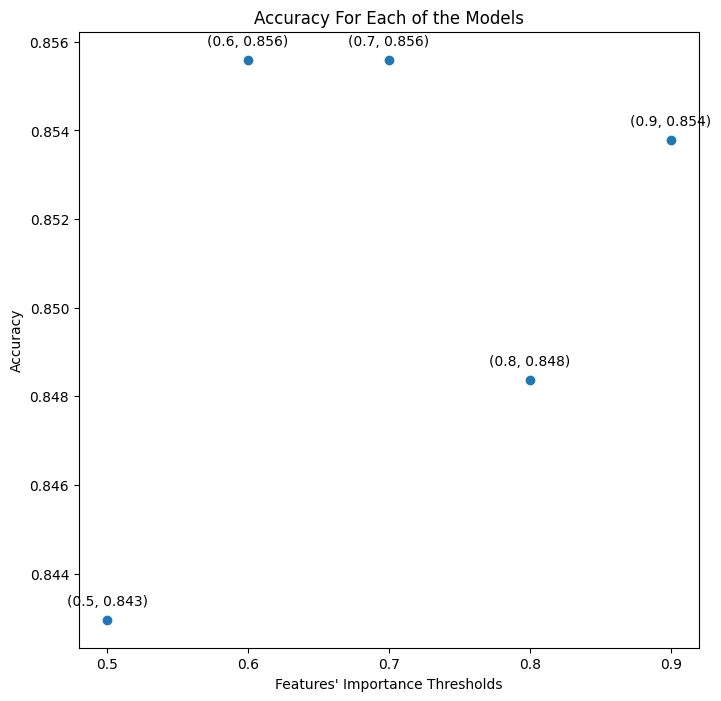

In [35]:
plt.figure(figsize = (8,8))
plt.scatter(thresholds, accuracies)
plt.xlabel("Features' Importance Thresholds")
plt.ylabel("Accuracy")
plt.title("Accuracy For Each of the Models")
plt.xticks(np.arange(0.5, 1, 0.1))
for i in range(len(thresholds)):
    plt.annotate(f"({thresholds[i]:.1f}, {accuracies[i]:.3f})", 
                 (thresholds[i], accuracies[i]),
                 textcoords="offset points", 
                 xytext=(0, 10),  # Offset the text slightly from the point
                 ha='center')
plt.show()

We can see how the accuracies vary,even if not by much, depending on the amount of features given to train the decision tree model. An optimum of 0.6 feature importances with 152 features fed to the model was acheived. 
This means we get a 86% accurate model (with other good metrics as could be seen below) with 22.8% out of the given coloumns. 

**Confusion Matrix and RUC for the 0.6 Threshold Random Forest Model**

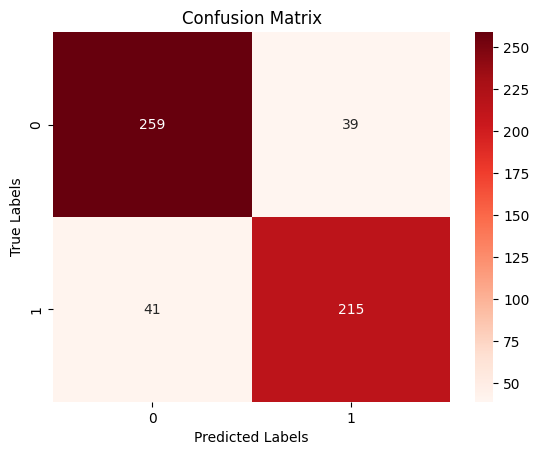

In [57]:
conf_matrix = confusion_matrix(y_test, y_pred_best)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

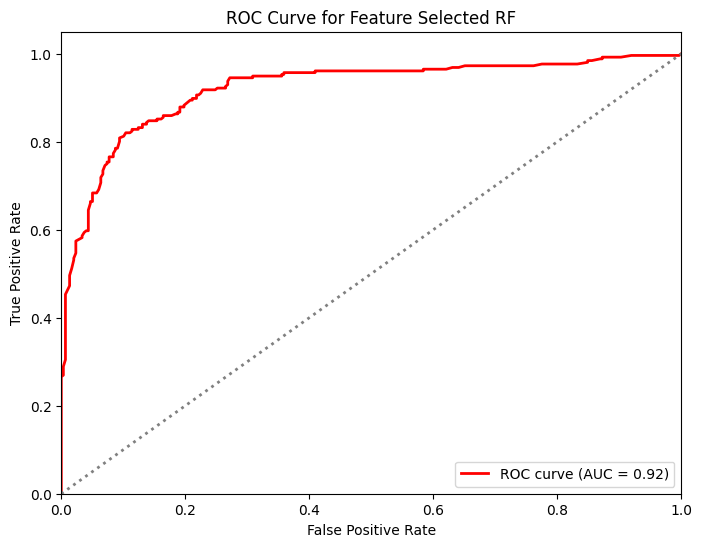

In [59]:
fpr, tpr, _ = roc_curve(y_test,y_pred_best_prob ) 
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='dotted', lw=2) 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for Feature Selected RF')
plt.legend(loc="lower right")
plt.show()

*****Model Performance*****

From the beginning we could see Random Forest is a better fir for this dataset and the epilepsy classification problem as it achieved better performance metrics than the logistic regression did without any special intervention. 

However by reducing the number of featuers used in training the model based on their initial importnace I have achived better results as well as mitigated the risk of creating an overfit model. Perhaps even in future use when trying to develop this model further it could cut costs as the less computing power would be needed than with the initial training data.

Further steps in improving this model's preformance should be random forest's parmaters optimization. This could be achived by using grid search cross validation

However I will now attempt in training a final model.

****XGBoost****

Since one of my main motives is consistancy and efficency, I am going to try and train this XGBosst model with the best dataset found on the random forest feature importance test.

In [38]:
from xgboost import XGBClassifier
X_train, X_test, y_train, y_test = train_test_split(X_reduced_copy[1], y, test_size=0.25, random_state=123)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=123)
xgb_model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred_xgb = xgb_model.predict(X_test)
y_pred_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]
print(f"XGBoost Accuracy: {accuracy_score(y_test, y_pred_xgb)}")
print(classification_report(y_test, y_pred_xgb))

XGBoost Accuracy: 0.8664259927797834
              precision    recall  f1-score   support

           0       0.88      0.87      0.88       298
           1       0.85      0.86      0.86       256

    accuracy                           0.87       554
   macro avg       0.87      0.87      0.87       554
weighted avg       0.87      0.87      0.87       554



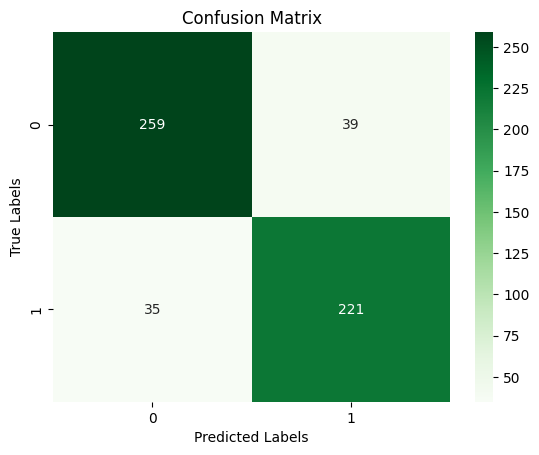

In [39]:
conf_matrix = confusion_matrix(y_test, y_pred_xgb)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

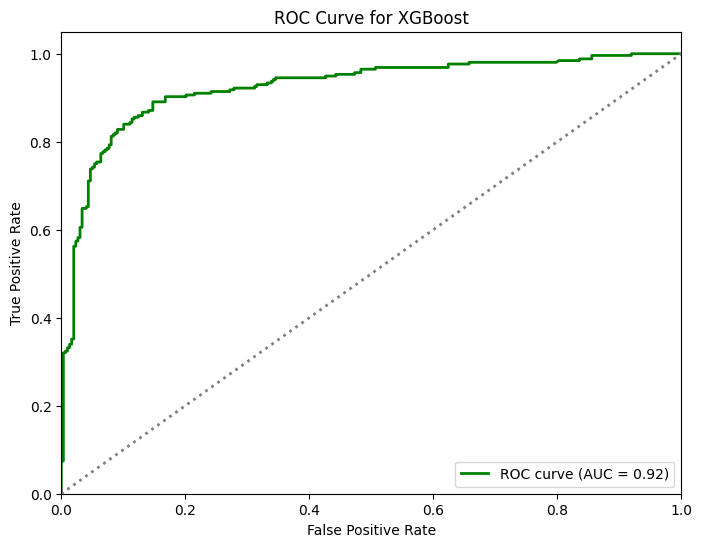

In [41]:
fpr, tpr, _ = roc_curve(y_test,y_pred_prob_xgb ) 
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='dotted', lw=2) 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for XGBoost')
plt.legend(loc="lower right")
plt.show()

We can already see better preformance than both prior models, as accuracy is a bit higher and AUC is high.
However I will try to imporve it.

Xbgoost has a built in feature importance and selection when building its decision tree but we can try to set different parameters for that tree in order to achieve better results.

In [51]:
from sklearn.model_selection import GridSearchCV

xgb_model = XGBClassifier(objective='binary:logistic',use_label_encoder=False, eval_metric='logloss', random_state=123)#,tree_method='hist', device='cuda')

# Define the grid of hyperparameters
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01,0.1, 0.2],
    'subsample': [0.9, 1.0],
    'colsample_bytree': [0.8, 0.9],
    'gamma': [0.2,0.3],
    'reg_alpha': [0.01,0.1],
    'reg_lambda': [1.5, 2.0]
}
# param_grid = {
#     'n_estimators': [ 300, 500],
#     'max_depth': [ 5, 7],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'subsample': [ 0.8, 1.0],
#     'colsample_bytree': [0.5, 0.7],
#     'gamma': [0.3, 0.5],
#     'min_child_weight': [5, 10]
# }


# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='accuracy', cv=3, verbose=1, n_jobs=-1)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Best parameters found
print("Best parameters found: ", grid_search.best_params_)

# Best model score
print("Best cross-validation accuracy: {:.2f}".format(grid_search.best_score_))

# Evaluate the model on the test set
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print(f"Test set accuracy: {test_accuracy:.2f}")

Fitting 3 folds for each of 576 candidates, totalling 1728 fits
Best parameters found:  {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0.01, 'reg_lambda': 1.5, 'subsample': 1.0}
Best cross-validation accuracy: 0.86
Test set accuracy: 0.85


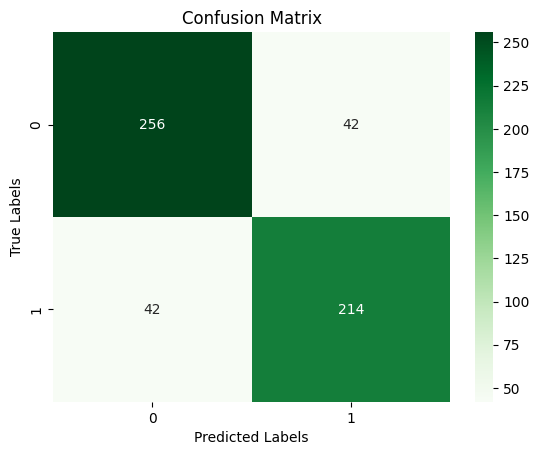

In [54]:
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  

conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

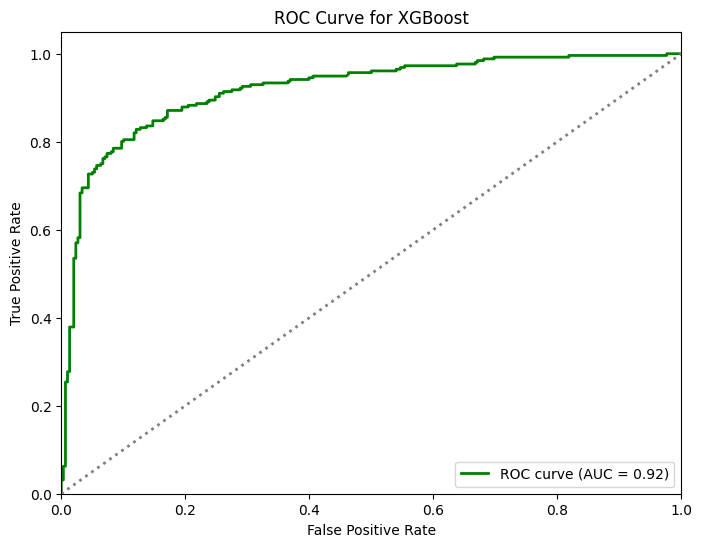

In [56]:
fpr, tpr, _ = roc_curve(y_test,y_pred_proba ) 
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='dotted', lw=2) 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for XGBoost')
plt.legend(loc="lower right")
plt.show
